In [428]:
import torch 
import matplotlib.pyplot as plt 
import numpy as np
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes, AdaptiveLIFNodes
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_spikes, plot_voltages
from bindsnet.learning import PostPre
from bindsnet.analysis.visualization import summary, plot_spike_trains_for_example, plot_voltage
from bindsnet import encoding

In [429]:
#define the helper's function

def loss_output(y,a_out):
    '''
    calculate the objective/Loss function
    at the last layer
    output : Loss tensor
    :param y (tensor): target label : 
    :param a_out (tensor): spike activity at the output layer
    '''
    o = torch.sum(a_out,dim=0) / torch.max(torch.sum(a_out,dim=0))
    Loss = 0.5 * torch.pow(torch.norm(o - y),2)
    return Loss

def error_backprop_out(y,a_out):
    '''
    calculate the error at the output layer
    output : loss tensor
    param
    param
    '''
    o_vec = torch.sum(a_out,dim=0) / torch.max(torch.sum(a_out,dim=0))
    delta_Loss = (o_vec - y) / np.sqrt(torch.count_nonzero(o_vec - y))
    return delta_Loss


def error_backprop(net,a_hidden,a_out,deltai_nxt):
    '''
    calculate the backprop error for each layer except output layer
    output : the error backprop tensor with dimension 1 x Number of neurons in that layer
    :param : net, network object
    :input : input data
    :a_hidden : spike activity output at the hidden layer
    :a_out : spike activit output at the output/last layer
    :deltai_nxt : backprop error from the next layer
    '''
    w = list(net.parameters())
    wij = w[2]          #get the weight of the hidden layer
    Vth = net.layers["B"].thresh
    M = net.layers["B"].n#total synapses in the next layer
    m = torch.sum(a_out,dim=0).nonzero()#vector of active synapses in the next layer  
    n = torch.sum(a_hidden,dim=0).nonzero() #vector of active neuron in the next layer
    g_i   = 1 / Vth
    g_bar = np.sqrt((1/len(n)) * torch.sum(torch.pow(g_i[m],2)))
    deltai = (g_i / g_bar) * np.sqrt(M/torch.sum(m)) * (wij @ deltai_nxt)
    return deltai
    #return g_bar
    
def delta_weight(etaw,N,m,deltai,xj):
    '''
    calculate the delta weights in each layer
    output : the vector of weight of each layer
    input : etaw, learning rate
    input : N, total neuron in layer
    input : m, total of active synapses in layer
    input : deltai, vector of error backprop
    input : xj,vector of effective input spike activity
    '''
    di = torch.reshape(deltai,[1,len(deltai)])
    x_j = torch.sum(xj,dim=0)
    x_j = x_j.reshape([len(x_j),1])
    return -etaw * np.sqrt(N/m) * di * x_j

def delta_thrs(etath,N,m,M,deltai,ai):
    '''
    calculate the delta threshold in each neuron in layer
    output : the vector of voltage threshold of each layer
    input : etath, learning rate
    input : N, total neuron in layer
    input : m, total of active synapses in layer
    input : M, total synapses in the layer
    input : deltai, vector of error backprop
    input : xj,vector of effective output spike activity
    '''
    #di  = torch.reshape(deltai,[1,len(deltai)])
    #a_i = torch.sum(ai,dim=0)
    #a_i = a_i.reshape([len(a_i),1])
    return -etath * np.sqrt(N/(m*M)) * deltai * torch.sum(ai,dim=0)


def update_params(net,etaw,etath,di_out,di_hid,a_out,a_hid,x_out,x_hid):
    '''
    calculate the delta weights and thresholds and update its value
    :input : net
    :
    '''
    N_out   = net.layers["C"].n#total neuron in the output layer
    N_hid   = net.layers["B"].n#total neuron in the hidden layer
    M_out   = N_hid #total synapses in the output layer
    M_hid   = net.layers["A"].n#total synapses in the hidden layer

    m_out   = len(torch.sum(a_out,dim=0).nonzero())#total active synapses in the output layer
    m_hid   = len(torch.sum(a_hidden,dim=0).nonzero())#total active synapses in the hidden layer

    w   = list(net.parameters())
    vth = [net.layers["B"].thresh,net.layers["C"].thresh]

    #1. weight in the last layer
    dwout = delta_weight(etaw,N_out,m_out,di_out,x_out)
    
    w[2].add_(dwout) #update the parameters
    #2. weight in the middle layer
    dwhid = delta_weight(etaw,N_hid,m_hid,di_hid,x_hid)
    w[0].add_(dwhid) #update the parameters
    
    #3. threshold in the last layer
    d_thout = delta_thrs(etath,N_out,m_out,M_out,di_out,a_out)
    vth[1].add_(d_thout)
    #4. threshold in the middle layer
    d_thid = delta_thrs(etath,N_hid,m_hid,M_hid,di_hid,a_hid)
    vth[0].add_(d_thid)

    
    

In [430]:
#simulation time
time = 500 #in millisecond
batch = 5 #batch size

#other parameters according Lee et.al(2016)
alpha = [10 ,3]
beta  = 10
lamda = 0.002
rho   = 0.0001
eta_w  = 0.02        #learning rate for synaptic weight
eta_th = 0.1 * eta_w  #learning rate for voltage threshold
T_ref = 1               #refractory period
t_mp  = 100            #decay time
v_rest = -65          #default neuron rest voltage
v_thresh   = -52          #default neuron threshold voltage

#create the network
network = Network()
#create and add input, output layers

#voltage threshold as a vector 
# the value corresponds to every vth in each node
nodes = [20, 10, 4] #number of nodes in each layer

#initialize the voltage threshold
vth = [alpha[0]*np.sqrt(3.0/nodes[0]), alpha[1]*np.sqrt(3.0/nodes[1])]


thres1 = (v_rest+ vth[0]) + torch.zeros(1,nodes[1])
thres2 = (v_rest+vth[1]) + torch.zeros(1,nodes[2])

source_layer = Input(n=nodes[0],traces=True)
hidden_layer = LIFNodes(n=nodes[1],trace=True,refrac=T_ref,thresh=thres1.squeeze(),tc_decay=t_mp,lbound=v_rest - vth[0])
target_layer = LIFNodes(n=nodes[2],traces=True,refrac=T_ref,thresh=thres2.squeeze(),tc_decay=t_mp,lbound=v_rest - vth[1])
#target_layer = AdaptiveLIFNodes(n=4, traces=True,refrac=1,thresh=)

network.add_layer(
    layer = source_layer, name="A"
)
network.add_layer(
    layer = hidden_layer, name="B"
)
network.add_layer(
    layer = target_layer, name="C"
)


In [431]:
#create a connection between input and hidden layers
forward_connection1 = Connection(
    source = source_layer,
    target= hidden_layer,
    #weight initialization according to Lee et.al
    w = (np.sqrt(3.0/source_layer.n)) - 2*np.sqrt(3.0/source_layer.n)*torch.rand(source_layer.n, hidden_layer.n),
)

network.add_connection(
    connection=forward_connection1, source="A", target="B"
)

#create a connection between hidden layer and output layer
forward_connection2 = Connection(
    source = hidden_layer,
    target = target_layer,
    #weight initialization according to Lee et.al
    w = (np.sqrt(3.0/hidden_layer.n)) - 2*np.sqrt(3.0/hidden_layer.n)*torch.rand(hidden_layer.n, target_layer.n),
    
)

network.add_connection(
    connection=forward_connection2, source="B", target="C"
)

In [432]:
#create a recurrent connection in output layer
# Winner take all circuit
recurrent_connection = Connection(
    source = target_layer,
    target= target_layer,
    w = 0.001 * (torch.eye(target_layer.n)-1),
)

network.add_connection(
    connection=recurrent_connection, source="C", target="C"
)

In [403]:
""" #investigate the weight in forward and recurrent connection
w1 = forward_connection1.w
w2 = forward_connection2.w
k1 = recurrent_connection.w 

print("max and min of 1st forward connection weights"+str(torch.max(w1))+" "+str(torch.min(w1)))
print("max and min of 2nd forward connection weights"+str(torch.max(w2))+" "+str(torch.min(w2)))
print("max and min of recurrent weights "+str(torch.max(k1))+" "+str(torch.min(k1))) """

max and min of 1st forward connection weightstensor(0.3866) tensor(-0.3850)
max and min of 2nd forward connection weightstensor(0.5225) tensor(-0.5415)
max and min of recurrent weights tensor(0.) tensor(-0.0010)


In [433]:
#create and add input and output layer monitor
source_monitor = Monitor(
    obj = source_layer,
    state_vars = ("s",), #record spikes and voltages
    time = time, 
)

hidden_monitor = Monitor(
    obj = hidden_layer,
    state_vars=("s","v"),
    time = time,
)

target_monitor = Monitor(
    obj = target_layer,
    state_vars= ("s", "v"),
    time = time,
)

network.add_monitor(monitor=source_monitor, name="A")
network.add_monitor(monitor=hidden_monitor, name="B")
network.add_monitor(monitor=target_monitor, name="C")
#print th network summary
print(summary(network))

In [435]:
#create input spike data, where each spike is distributed according bernoulli
#input_data = torch.bernoulli(0.1 * torch.ones(time, source_layer.n)).byte()
#inputs = {"A":input_data}

input_rates = 350 * torch.rand(source_layer.n)  # Generate random Poisson rates for N input neurons.
input= encoding.poisson(datum=input_rates, time=time)  # Encode input as time ms Poisson spike trains.
inputs = {"A":input}

y = torch.tensor([0, 0, 1, 0],dtype=torch.uint8) #target label
#simulate network on input data
network.run(inputs=inputs,time=time)


<Figure size 432x288 with 0 Axes>

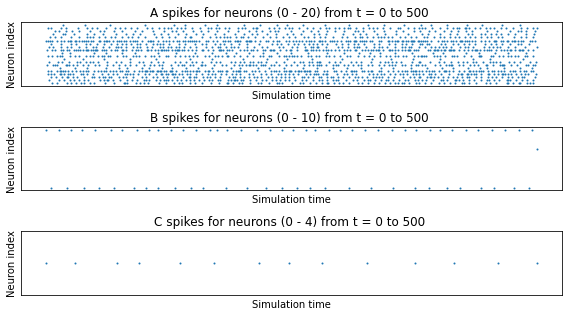

<Figure size 432x288 with 0 Axes>

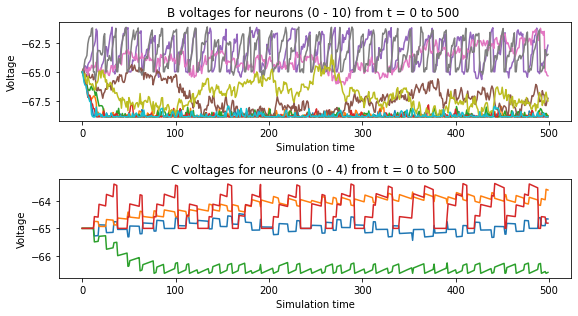

In [436]:
#retrieve and plot simulation spike voltage data from monitors
spikes = {
    "A" : source_monitor.get("s"),
    "B" : hidden_monitor.get("s"),
    "C" : target_monitor.get("s")
}

voltages = {"B": hidden_monitor.get("v"),
            "C": target_monitor.get("v")}

plt.ioff()
plt.figure()
plot_spikes(spikes)
plt.figure()
plot_voltages(voltages, plot_type="line")
plt.show()

In [439]:
#begin the training procedure

#loop for 150 epochs
epochs = 150
L = torch.zeros(1,epochs) #store in the vector

for i in range(epochs):
    #1. run forward propagation 
    network.run(inputs=inputs,time=time)
    #1.1 obtain the spike activity in each nodes of every layer
    #x -> 
    a_hidden = spikes["B"].squeeze().float() #get the spike activity at the hidden layer
    a_out    = spikes["C"].squeeze().float() #get the spike activity at the output layer
    
    x_hidden = input
    x_out    = a_hidden

    #2. calculate and keep track the loss
    L[0,i] = loss_output(y,a_out)
    if (i % 9==0): #print loss every 10 counts
        print("Iteration "+str(i)+" Loss"+str(L[0,i]))
    #3.propagate the error backprop
    
    delta_i_out    =  error_backprop_out(y,a_out)
    delta_i_hid    =  error_backprop(network,a_hidden,a_out,delta_i_out)
    print(delta_i_out)
    #print(delta_i_hid)
    #4.update the paramaters (weight & threshold)
    update_params(network,eta_w,eta_th,delta_i_out,delta_i_hid,a_out,a_hidden,x_out,x_hidden)
    

#print(delta_i_out)
#print((delta_i_hid))
print(L)

Iteration 0 Losstensor(1.0000)
tensor([ 0.0000,  0.0000, -0.7071,  0.7071])
tensor([ 0.0000,  0.0000, -0.7071,  0.7071])
tensor([ 0.0000,  0.0000, -0.7071,  0.7071])
tensor([ 0.0000,  0.0000, -0.7071,  0.7071])
tensor([ 0.0000,  0.0000, -0.7071,  0.7071])
tensor([ 0.0000,  0.0000, -0.7071,  0.7071])
tensor([ 0.0000,  0.0000, -0.7071,  0.7071])
tensor([ 0.0000,  0.0000, -0.7071,  0.7071])
tensor([ 0.0000,  0.0000, -0.7071,  0.7071])
Iteration 9 Losstensor(1.0000)
tensor([ 0.0000,  0.0000, -0.7071,  0.7071])
tensor([ 0.0000,  0.0000, -0.7071,  0.7071])
tensor([ 0.0000,  0.0000, -0.7071,  0.7071])
tensor([ 0.0000,  0.0000, -0.7071,  0.7071])
tensor([ 0.0000,  0.0000, -0.7071,  0.7071])
tensor([ 0.0000,  0.0000, -0.7071,  0.7071])
tensor([ 0.0000,  0.0000, -0.7071,  0.7071])
tensor([ 0.0000,  0.0000, -0.7071,  0.7071])
tensor([ 0.0000,  0.0000, -0.7071,  0.7071])
Iteration 18 Losstensor(1.0000)
tensor([ 0.0000,  0.0000, -0.7071,  0.7071])
tensor([ 0.0000,  0.0000, -0.7071,  0.7071])
tensor

In [397]:
""" N_out   = network.layers["C"].n#total neuron in the output layer
N_hid   = network.layers["B"].n#total neuron in the hidden layer
M_out   = N_hid #total synapses in the output layer
M_hid   = network.layers["A"].n#total synapses in the hidden layer
m_out   = len(torch.sum(a_out,dim=0).nonzero())#total active synapses in the output layer
m_hid   = len(torch.sum(a_hidden,dim=0).nonzero())#total active synapses in the hidden layer
w   = list(network.parameters())
vth = [network.layers["B"].thresh,network.layers["C"].thresh]

#dwout = delta_weight(eta_w,N_out,m_out,delta_i_out,x_out)
d_thout = delta_thrs(eta_th,N_out,m_out,M_out,delta_i_out,a_out)
print(d_thout)
#print(delta_i_out.shape)
#print(torch.sum(a_out,dim=0).shape)
print(vth[1])
 """

' N_out   = network.layers["C"].n#total neuron in the output layer\nN_hid   = network.layers["B"].n#total neuron in the hidden layer\nM_out   = N_hid #total synapses in the output layer\nM_hid   = network.layers["A"].n#total synapses in the hidden layer\nm_out   = len(torch.sum(a_out,dim=0).nonzero())#total active synapses in the output layer\nm_hid   = len(torch.sum(a_hidden,dim=0).nonzero())#total active synapses in the hidden layer\nw   = list(network.parameters())\nvth = [network.layers["B"].thresh,network.layers["C"].thresh]\n\n#dwout = delta_weight(eta_w,N_out,m_out,delta_i_out,x_out)\nd_thout = delta_thrs(eta_th,N_out,m_out,M_out,delta_i_out,a_out)\nprint(d_thout)\n#print(delta_i_out.shape)\n#print(torch.sum(a_out,dim=0).shape)\nprint(vth[1])\n '

In [343]:

""" print(a_hidden.shape)
print(torch.sum(spikes["B"].squeeze().float(),dim=0))
print(torch.sum(a_hidden,dim=0))
print(a_out.shape)
print(torch.sum(a_out,dim=0))
print(x_hidden.shape)
print(torch.sum(x_hidden,dim=0)) """
""" print(w1.shape)
print(delta_i_hid.shape)
print(torch.sum(x_hidden,dim=0).shape)
print(w2.shape)
print(delta_i_out.shape)
print(torch.sum(x_out,dim=0).shape) """

torch.Size([20, 10])
torch.Size([10])
torch.Size([20])
torch.Size([10, 4])
torch.Size([4])
torch.Size([10])


In [348]:
""" at = torch.tensor([1,2,3])
ax = torch.tensor([4,5])
atn = torch.reshape(at,[len(at),1])
axn = torch.reshape(ax,[1,len(ax)])
print(atn.shape)
print(axn.shape)
print(atn * axn)
print(axn * atn)
at = at.reshape([1,len(at)])
 """


torch.Size([3, 1])
torch.Size([1, 2])
tensor([[ 4,  5],
        [ 8, 10],
        [12, 15]])
tensor([[ 4,  5],
        [ 8, 10],
        [12, 15]])


In [1116]:
""" #now update the weight and threshold and run the network again
new_weight = 0.05 + 0.06 * torch.randn(source_layer.n, target_layer.n),
snn_params = list(network.parameters())

for p in snn_params:
    p.add_(0.01)

theta_thrs = [-10, -8, -9, -10]
tempv = network.layers["B"].thresh

for i,v in enumerate(tempv):
    v.add_(theta_thrs[i])

#updated voltage threshold and synaptic weight
print(target_layer.thresh)
print(forward_connection.w)
 """

' #now update the weight and threshold and run the network again\nnew_weight = 0.05 + 0.06 * torch.randn(source_layer.n, target_layer.n),\nsnn_params = list(network.parameters())\n\nfor p in snn_params:\n    p.add_(0.01)\n\ntheta_thrs = [-10, -8, -9, -10]\ntempv = network.layers["B"].thresh\n\nfor i,v in enumerate(tempv):\n    v.add_(theta_thrs[i])\n\n#updated voltage threshold and synaptic weight\nprint(target_layer.thresh)\nprint(forward_connection.w)\n '